In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol, expand
from scipy.integrate import solve_ivp, ode
import time

import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

from utils import load_Lie_weights

Using TensorFlow backend.


In [2]:
def vdp_system(t, state, k=1):
    x = state[0]
    dx= state[1]
    return np.array([dx, dx-k*x*x*dx - x])

def solve_num(x0, t):
    X = solve_ivp(vdp_system, [0, t], x0, max_step=0.01)
    return X.y.T, X.t

def plot_num():
    for x0 in X0:
        X,_= solve_num(x0, T)
        plt.plot(X[:, 0], X[:, 1], 'r-', alpha = 0.7)
    return

In [3]:
X0 = np.array([[1, 2],
               [2, -2],
               [-3, -3],
               [-2, 4]], dtype=float).reshape((-1, 2))/1
T = 7

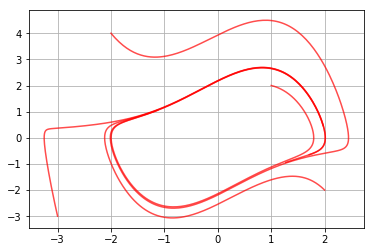

In [4]:
plot_num()
plt.grid()
plt.show()

In [5]:
W = load_Lie_weights('data/van_der_pol.txt', 2)
for w in W:
    print w.shape

('load weights: ', 'data/van_der_pol.txt')
start converting
(1,)
start converting
(2,)
start converting
(4,)
start converting
(8,)
start converting
(16,)
start converting
(32,)
start converting
(64,)
start converting
(128,)
(1, 2)
(2, 2)
(4, 2)
(8, 2)
(16, 2)
(32, 2)
(64, 2)
(128, 2)


Instructions for updating:
Colocations handled automatically by placer.
(701, 4, 2) (701,)


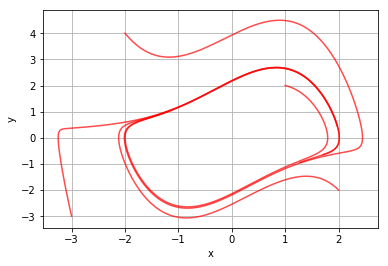

In [6]:
dim = 2
order = 7
map_lie = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
net_lie = Sequential()
net_lie.add(map_lie)
map_lie.set_weights([w*k for w,k in zip(W, [1, 1, 1, 1, 1, 1, 1, 1])])

def solve_net(model, line='b.', epoch_n = 700):
    X = np.ones((epoch_n+1, X0.shape[0], dim))
    X[0,:,:] = X0
    for i in xrange(epoch_n):
        X[i+1] = model.predict(X[i])
        
    #plt.plot(X[::10,:,0], X[::10,:,1], line, markersize=3, linewidth=1)
    return X

plot_num()
X_net = solve_net(net_lie, 'b.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

t = np.arange(0, 7.01, 0.01)
print X_net.shape, t.shape

In [7]:
def solve_num_interp(X0, T, t):
    x_ans = np.empty((t.shape[0], X0.shape[0], X0.shape[1]))
    for i, x0 in enumerate(X0):
        X = solve_ivp(vdp_system, [0, T], x0, max_step=0.01, method='RK23')
        for k in [0, 1]:
            x_ans[:, i, k] = np.interp(t, X.t, X.y[k])
    return x_ans

In [8]:
def solve_prec(X0, T, order=8, dt = 0.01):
    x_ans = np.empty((t.shape[0], X0.shape[0], X0.shape[1]))
    #r = ode(vdp_system).set_integrator('dop853', max_step=dt)
    r = ode(vdp_system).set_integrator('vode', max_step=dt, order=order)
    for i, x0 in enumerate(X0):
        r.set_initial_value(x0, 0)
        x_ans[:, i] = x0
        k=1
        while r.successful() and k<t.shape[0]:#r.t <= T:
            r.integrate(r.t+dt)
            x_ans[k, i, :] = r.y
            k+=1
    return x_ans

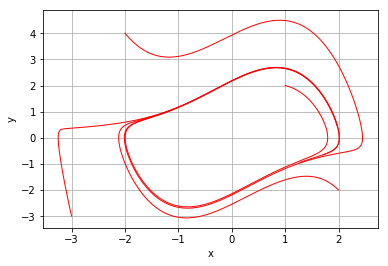

In [9]:
X_prec = solve_prec(X0, 7)
plt.plot(X_prec[:,:,0], X_prec[:,:,1], 'r-', markersize=3, linewidth=1)
X_net = solve_net(net_lie, 'b.')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

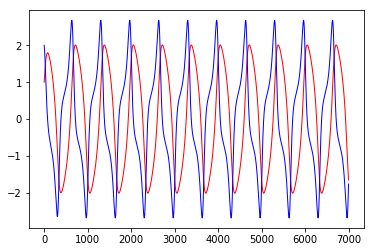

In [10]:
X_tmp = solve_num_interp(X0, 70, np.arange(0, 70.01, 0.01))
plt.plot(X_tmp[:,0,0], 'r-', markersize=3, linewidth=1)
plt.plot(X_tmp[:,0,1], 'b-', markersize=3, linewidth=1)

In [11]:

T=7
X_prec = solve_prec(X0, T, order=4, dt = 0.01)
#X_num = solve_prec(X0, T, order=3, dt = 0.01)
X_num = solve_num_interp(X0, 7, t)
X_net = solve_net(net_lie, 'b.')

#for x in [X_num, X_prec, X_net]:
#    x[:,:,0]/=4
#    x[:,:,1]/=5
    
err1 = np.abs(X_num - X_prec)/X_prec
err2 = np.abs(X_net - X_prec)/X_prec


#plt.plot(err2[:400,:,0], 'r-', markersize=3, linewidth=1)
#plt.plot(err2[:400,:,1], 'b-', markersize=3, linewidth=1)
#err1 = np.mean(np.linalg.norm(X_num - X_prec, axis=2))
#err2 = np.mean(np.linalg.norm(X_net - X_prec, axis=2))

err1 = np.mean(np.mean(err1, axis=0))
err2 = np.mean(np.mean(err2, axis=0))
print err1, err2


2.1481877826524784e-05 4.6588005318909445e-06


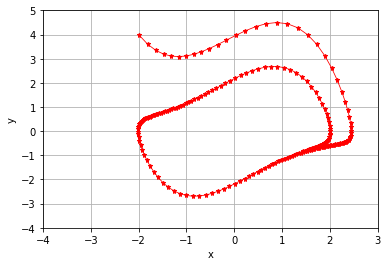

In [12]:
T = 1000*0.01
Xtrain, t = solve_num(X0[-1], T)
tt = np.arange(0, T+0.02, 0.01)
#Xtrain[:,0] = np.interp(tt, t, Xtrain[:,0])
#Xtrain[:,1] = np.interp(tt, t, Xtrain[:,1])
#plt.plot(Xtrain[::10], '*')
Xtrain[:,0] = np.interp(tt, t, Xtrain[:,0])
Xtrain[:,1] = np.interp(tt, t, Xtrain[:,1])
plt.plot(Xtrain[::5,0], Xtrain[::5,1], 'r*-', markersize=5, linewidth=0.8)

plt.xlim([-4, 3])
plt.ylim([-4, 5])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [13]:
def createLieNet(inputDim=2, outputDim=2, order=3):
    model = Sequential()
    model.add(LieLayer(output_dim = outputDim, order=order,
                      input_shape = (inputDim,)))
    opt = keras.optimizers.Adamax(lr=0.02, beta_1=0.99,
                                  beta_2=0.99999, epsilon=1e-1, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [14]:
import Van_der_Pole as vdp
from QUBO import qbsolve, solve_dwave
def learn(epochs):
    learn_net = createLieNet()
    loss=[]
    for i in xrange(epochs):
        history = learn_net.fit(Xtrain[:-1], Xtrain[1:], epochs=1, verbose=0)
        loss.append(history.history['loss'][-1])
        W = learn_net.get_weights()
    #print b.reshape((2, -1))
    print loss[-1]
    return learn_net, loss

Instructions for updating:
Use tf.cast instead.
6.324749959505196e-08


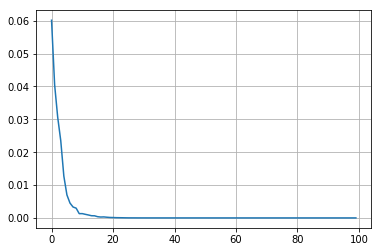

In [15]:
learn_net, loss = learn(100)

#plt.plot(lossQ)
plt.plot(loss)
plt.grid()

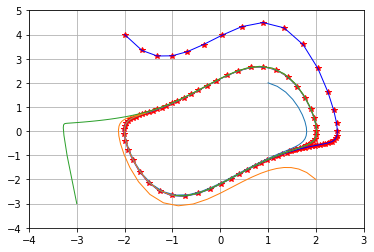

In [16]:
plt.plot(Xtrain[::10,0], Xtrain[::10,1], 'r*')
#solve_net(model_lie, 'b-')
#solve_net(learn_netQ, 'r-')
X = solve_net(learn_net, 'b-', epoch_n = 1000)
plt.plot(X[::10,-1,0], X[::10,-1,1], 'b-', markersize=3, linewidth=1)
plt.plot(X[::10,:-1,0], X[::10,:-1,1], markersize=3, linewidth=1)
plt.xlim([-4, 3])
plt.ylim([-4, 5])
plt.grid()

4.799156494348125e-05 -9.78545427197249e-06


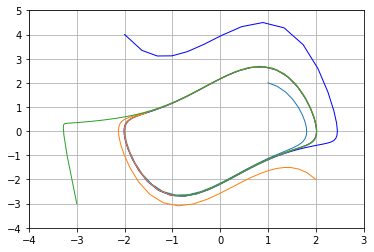

In [21]:
t = np.arange(0, 7.01, 0.01)
X_prec = solve_prec(X0, T, order=4, dt = 0.01)

err1 = np.abs(X_net[:,-1,:] - X_prec[:,-1,:])/X_prec[:,-1,:]
err2 = np.abs(X_net[:,:-1,:] - X_prec[:,:-1,:])/X_prec[:,:-1,:]


err1 = np.mean(np.mean(err1, axis=0))
plt.plot(X[::10,-1,0], X[::10,-1,1], 'b-', markersize=3, linewidth=1)
plt.plot(X[::10,:-1,0], X[::10,:-1,1], markersize=3, linewidth=1)
plt.xlim([-4, 3])
plt.ylim([-4, 5])
plt.grid()
err2 = np.mean(np.mean(err2, axis=0))
print err1, err2

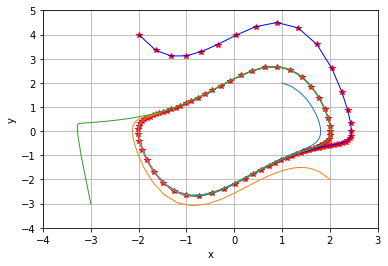

In [22]:
plt.plot(Xtrain[::10,0], Xtrain[::10,1], 'r*')
plt.plot(X[::10,-1,0], X[::10,-1,1], 'b-', markersize=3, linewidth=1)
plt.plot(X[::10,:-1,0], X[::10,:-1,1], markersize=3, linewidth=1)
plt.xlim([-4, 3])
plt.ylim([-4, 5])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()